# Dataset Analysis


In [ ]:
# PyTorch
import torch
from torch import nn

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

## Import the Fashion MNIST dataset

This guide uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc.) in a format identical to that of the articles of clothing you'll use here.

This guide uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code.

Here, 60,000 images are used to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from PyTorch through *torchvision* library.

In [ ]:
# Loading the Fashion-MNIST dataset
from torchvision import datasets, transforms


# Download and load the training data

transform = transforms.Compose([transforms.ToTensor()])

# datasets
trainset = datasets.FashionMNIST('./data',
    download=True,
    train=True,
    transform=transform)

testset = datasets.FashionMNIST('./data',
    download=True,
    train=False,
    transform=transform)

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## Explore the data

Let's explore the format of the dataset before training the model. The following shows there are 60,000 images in the training set, with each image represented as 28 x 28 pixels with 1 channel (B&W images)

In [ ]:
len(trainset), trainset[0][0].shape

(60000, torch.Size([1, 28, 28]))

Each label is an integer between 0 and 9. So this list is empty.

In [ ]:
[l for i, l in trainset if l > 10 or l < 0]

[]

There are 10,000 images in the test set. Again, each image is represented as 28 x 28 pixels:

In [ ]:
len(testset), testset[0][0].shape

(10000, torch.Size([1, 28, 28]))

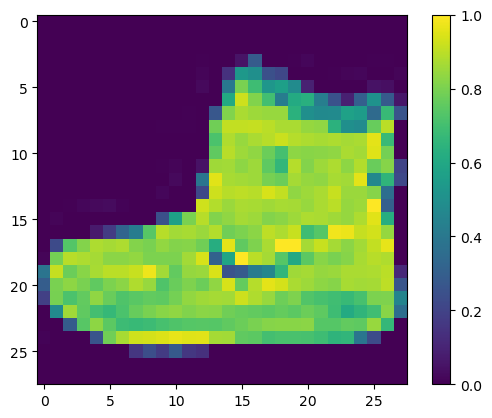

In [ ]:
plt.figure()
plt.imshow(trainset[0][0].squeeze().numpy())
plt.colorbar()
plt.grid(False)
plt.show()

To verify that the data is in the correct format and that you're ready to build and train the network, let's display the first 25 images from the *training set* and display the class name below each image.

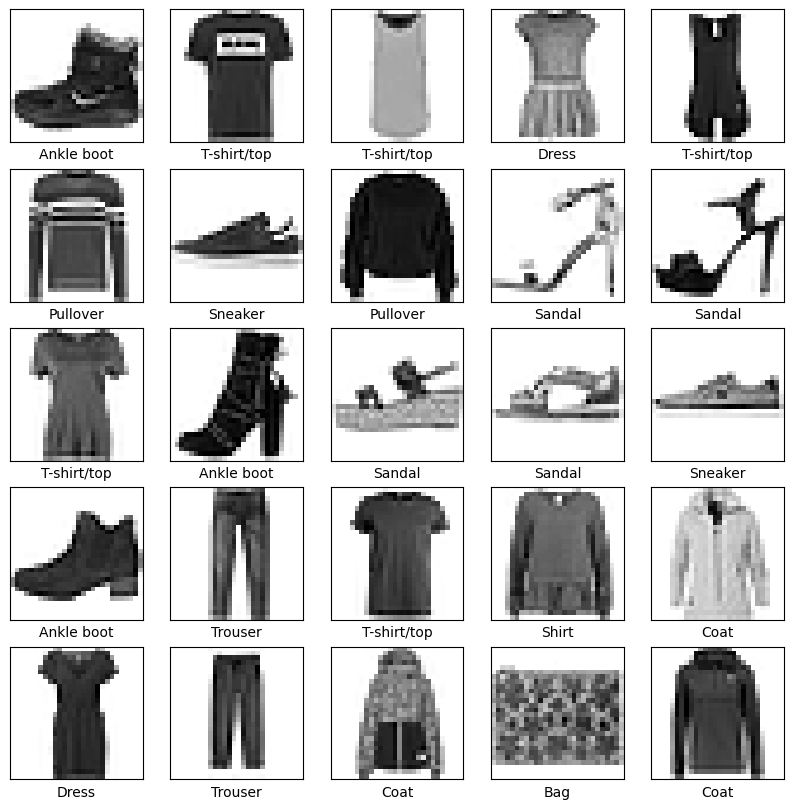

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(trainset[i][0].squeeze(0), cmap=plt.cm.binary)
    plt.xlabel(class_names[trainset[i][1]])
plt.show()

Last thing we have to load the datasets in an apposite iterable structure called [*dataloader*](https://pytorch.org/docs/stable/data.html).This structure also takes care of dividing the dataset into batches.

For larger datasets this operation can be significantly speeded up thanks to the multi process support.

In [ ]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(testset, batch_size=1)

In [ ]:
for image, label in train_loader:

    print(image.shape)
    print(label.shape)

    break

torch.Size([64, 1, 28, 28])
torch.Size([64])


The first element of the *shape* attribute now represents the number of images in the batch

# Adapt TensorFlow code to PyTorch

## Build the model

Building the neural network requires configuring the layers of the model.

### Set up the layers

The basic building block of a neural network is the [*torch.nn*](https://pytorch.org/docs/stable/nn.html)  package. Layers extract representations from the data fed into them. Hopefully, these representations are meaningful for the problem at hand.

Most of deep learning consists of chaining together simple layers. Most layers, such as `nn.Linear`, have parameters that are learned during training.

In PyTorch we can load a model into a device, like CPU or GPU, to boost the performance.

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = nn.Sequential(
            nn.Flatten(1, -1),
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        ).to(device)

print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=10, bias=True)
)


The first layer in this network, `nn.Flatten`, transforms the format of the images from a three-dimensional array (1 x 28 x 28) to a one-dimensional array (of 1 * 28 * 28 = 784 pixels). When building this layer we have to take into account that the first/zero dimension of the Tensor represent the number of element in the batch.

 Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn; it only reformats the data.

After the pixels are flattened, the network consists of a sequence of two `nn.Linear` layers. These are densely connected, or fully connected, neural layers. The first `Linear` layer has 128 nodes (or neurons). The second (and last) layer returns a logits array with length of 10. Each node contains a score that indicates the current image belongs to one of the 10 classes.

## Train the model

To start training,  first we have to define the loss function (the *criterion*) and the [*optimizer*](https://pytorch.org/docs/stable/optim.html).

In [ ]:
from torch import optim

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10

Training the neural network with PyTorch requires slightly more effort than with TensorFlow. But, the same training script can be used for all PyTorch models.

In [ ]:
from tqdm import tqdm


train_loss = []
train_accs = []

# Loop over epochs.
for ep in range(epochs):
    model.train()
    running_loss = 0.0
    acc = 0
    total = 0

    # Loop over batches.
    for it, (images, labels) in enumerate(tqdm(train_loader)):

        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        logits = model(images)
        loss = criterion(logits, labels)

        running_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Refresh gradient to prevent gradient accumulation.
        optimizer.zero_grad()

        # Compute accuracy
        predictions = torch.max(logits, 1).indices.to(device)

        acc += (predictions.detach().cpu().numpy() == labels.detach().cpu().numpy()).sum()
        total += len(labels)

    epoch_loss = running_loss/len(train_loader)
    train_loss.append(epoch_loss)

    epoch_acc = acc*100/total
    train_accs.append(epoch_acc)

    print(f"Epoch {ep+1}: Loss {round(epoch_loss, 3)} - Accuracy {round(epoch_acc, 2)}%\n")

100%|██████████| 938/938 [00:05<00:00, 157.45it/s]


Epoch 1: Loss 0.55 - Accuracy 81.01%



100%|██████████| 938/938 [00:05<00:00, 176.50it/s]


Epoch 2: Loss 0.402 - Accuracy 85.8%



100%|██████████| 938/938 [00:05<00:00, 178.22it/s]


Epoch 3: Loss 0.359 - Accuracy 87.09%



100%|██████████| 938/938 [00:05<00:00, 177.61it/s]


Epoch 4: Loss 0.331 - Accuracy 87.99%



100%|██████████| 938/938 [00:05<00:00, 187.08it/s]


Epoch 5: Loss 0.311 - Accuracy 88.68%



100%|██████████| 938/938 [00:04<00:00, 188.14it/s]


Epoch 6: Loss 0.294 - Accuracy 89.22%



100%|██████████| 938/938 [00:04<00:00, 189.61it/s]


Epoch 7: Loss 0.281 - Accuracy 89.74%



100%|██████████| 938/938 [00:05<00:00, 185.71it/s]


Epoch 8: Loss 0.269 - Accuracy 90.16%



100%|██████████| 938/938 [00:04<00:00, 189.11it/s]


Epoch 9: Loss 0.26 - Accuracy 90.49%



100%|██████████| 938/938 [00:04<00:00, 190.24it/s]

Epoch 10: Loss 0.25 - Accuracy 90.74%



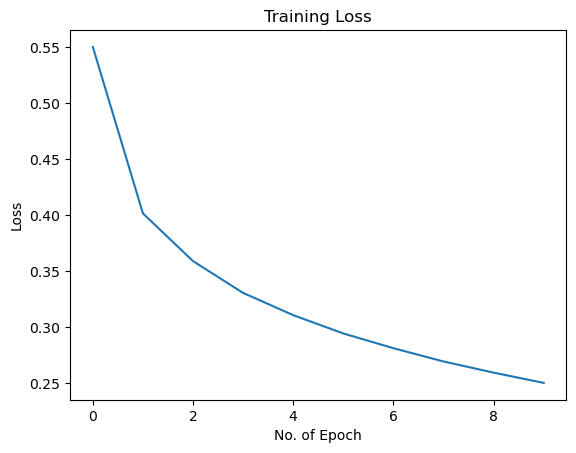

In [ ]:
plt.plot(range(epochs), train_loss)
plt.xlabel("No. of Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

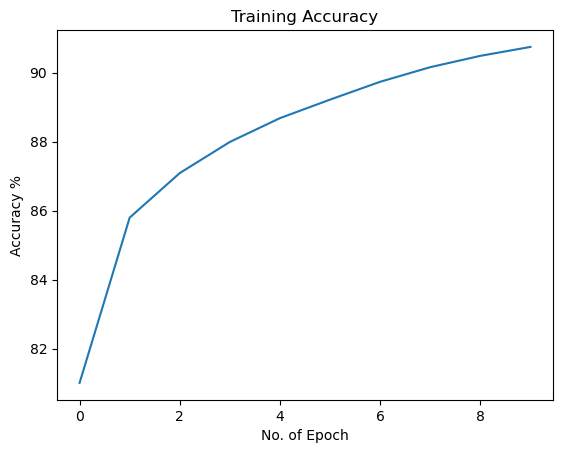

In [ ]:
plt.plot(range(epochs), train_accs)
plt.xlabel("No. of Epoch")
plt.ylabel("Accuracy %")
plt.title("Training Accuracy")
plt.show()

### Evaluate accuracy

Next, compare how the model performs on the test dataset:

In [ ]:
model.eval()
val_acc = 0

for it, (images, labels) in enumerate(tqdm(test_loader)):

    with torch.no_grad():
        images = images.to(device)

        logits = model(images)
        predictions = torch.max(logits, 1).indices

        val_acc += (predictions.detach().cpu().numpy() == labels.detach().cpu().numpy()).sum()

print(f"\nTrained model Accuracy on testset: {round(val_acc*100/len(test_loader), 3)}%")

100%|██████████| 10000/10000 [00:03<00:00, 2898.72it/s]


Trained model Accuracy on testset: 87.37%


It turns out that the accuracy on the test dataset is a little less than the accuracy on the training dataset. This gap between training accuracy and test accuracy represents *overfitting*. Overfitting happens when a machine learning model performs worse on new, previously unseen inputs than it does on the training data. An overfitted model "memorizes" the noise and details in the training dataset to a point where it negatively impacts the performance of the model on the new data.

### Make predictions

With the model trained, you can use it to make predictions about some images.
Attach a softmax layer to convert the model's linear outputs—[logits](https://developers.google.com/machine-learning/glossary#logits)—to probabilities, which should be easier to interpret.

In [ ]:
prob_model = nn.Sequential(model, nn.Softmax(dim=1))
prob_model.to(device)

Sequential(
  (0): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
  (1): Softmax(dim=1)
)

In [ ]:
prob_model.eval()
predictions = []

for it, (images, labels) in enumerate(tqdm(test_loader)):

    with torch.no_grad():
        images = images.to(device)
        predictions.append(prob_model(images).detach().cpu().numpy()[0])

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:03<00:00, 2954.68it/s]


Here, the model has predicted the label for each image in the testing set. Let's take a look at the first prediction:

In [ ]:
predictions[0]

array([1.7363938e-06, 3.3854221e-08, 3.5379063e-07, 8.5422454e-07,
       2.1434239e-06, 7.9481611e-03, 7.9682184e-07, 2.3634939e-02,
       2.2009572e-05, 9.6838903e-01], dtype=float32)

A prediction is an array of 10 numbers. They represent the model's "confidence" that the image corresponds to each of the 10 different articles of clothing. You can see which label has the highest confidence value:

In [ ]:
np.argmax(predictions[0])

9

So, the model is most confident that this image is an ankle boot, or `class_names[9]`. Examining the test label shows that this classification is correct:

In [ ]:
testset[0][1]

9

Graph this to look at the full set of 10 class predictions.

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

### Verify predictions

With the model trained, you can use it to make predictions about some images.

Let's look at the 0th image, predictions, and prediction array. Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percentage (out of 100) for the predicted label.

In [ ]:
test_images = [i.squeeze(0) for i, l in testset]
test_labels = [l for i, l in testset]

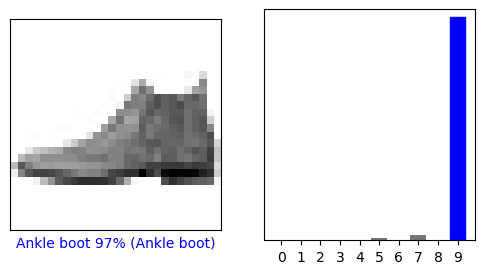

In [ ]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

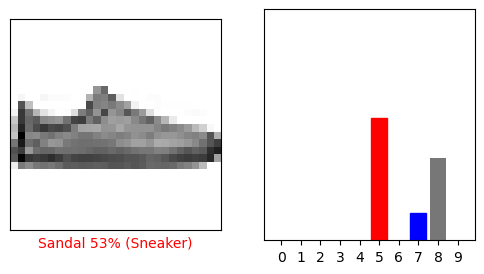

In [ ]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

Let's plot several images with their predictions. Note that the model can be wrong even when very confident.

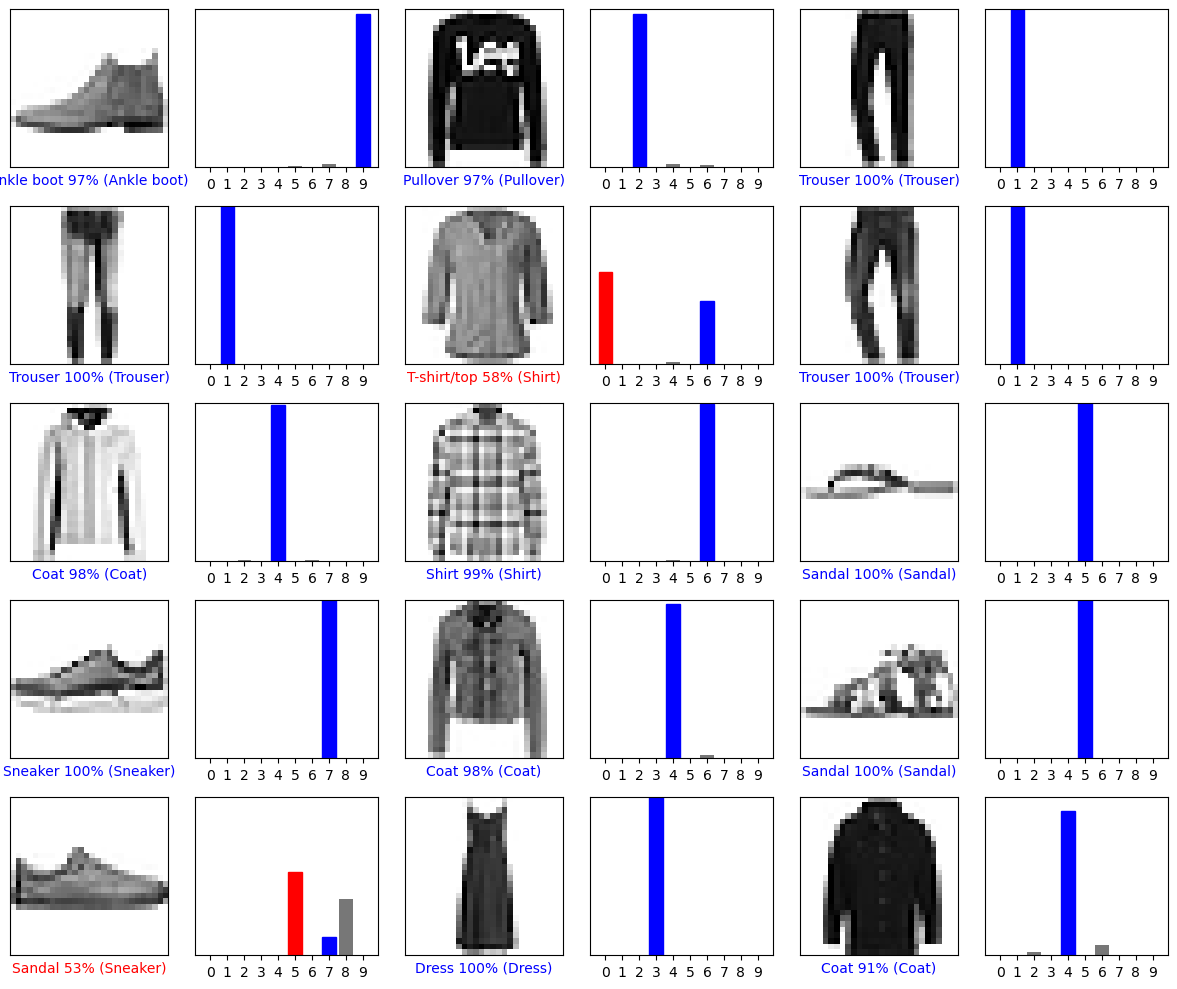

In [ ]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

# A real PyTorch implementation

Now we present the correct way to build and use a PyTorch model.

## Import and wrap the Fashion MNIST dataset

A good practice when using PyTorch is to extend the *Dataset* class to better manage data. Every subclasses must extend the following methods:

*   **\_\_init\_\_** : class constructor, here are specified the data and the parameters;
*   **\_\_getitem\_\_**: method called implicit later by the *dataloader* to pass the data to the model;
*   **\_\_len\_\_**: method that specify the length of the dataset;

Other methods can be added to better manage the data.


In [ ]:
from torch.utils.data import Dataset

class FashionDataset(Dataset):

    def __init__(self, data):
        self.images = [i.squeeze(0) for i, l in data]
        self.labels = [l for i, l in data]

        self.class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                            'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


    def __getitem__(self, index):
        label = self.labels[index]
        image = self.images[index]

        return image, label

    def __len__(self):
        return len(self.images)

    def get_labels(self):
        return self.labels

    def get_name(self, label):
        return self.class_names[label]

    def get_images(self):
        return self.images

In [ ]:
dataset_train = FashionDataset(trainset)
dataset_test = FashionDataset(testset)

## Build the model

Following the PyTorch best practice, a model is built by extending the `nn.Module` class. Even in this case every subclasses have to extend the following methods:

*   **\_\_init\_\_**: class constructor, here are specified the layers of the model;
*   **forward**: method that rapresent the forward pass of the model

Methods for wrapping training, evaluation and prediction operation can be added in this class.



In [ ]:
from tqdm import tqdm

class FashionModel(nn.Module):

    def __init__(self, num_labels, hidden_size=128):
        super(FashionModel, self).__init__()

        self.flatten = nn.Flatten(1, -1)

        self.linear1 = nn.Linear(784, hidden_size)
        self.batchnorm1 = nn.BatchNorm1d(hidden_size)
        self.dropout1 = nn.Dropout(0.2)

        self.linear2 = nn.Linear(hidden_size, num_labels)

        self.relu = nn.ReLU()

        self._initialize_weights()

    def _initialize_weights(self):
        nn.init.constant_(self.linear1.weight, 1)
        nn.init.constant_(self.linear1.bias, 0)


    def forward(self, img):
        x = self.flatten(img)

        x = self.linear1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.dropout1(x)

        x = self.linear2(x)
        x = self.relu(x)

        return x


    def train_classifier(self, dataloader, epochs, criterion, optimizer, device):
        train_loss = []
        train_accs = []

        for ep in range(epochs):
            self.train()
            running_loss = 0.0
            acc = 0
            total = 0

            for it, (images, labels) in enumerate(tqdm(dataloader)):

                images = images.to(device)
                labels = labels.to(device)

                # Forward pass
                logits = self.forward(images)
                loss = criterion(logits, labels)

                running_loss += loss.item()

                # Backpropagation
                loss.backward()
                optimizer.step()

                optimizer.zero_grad()

                # Accuracy
                predictions = torch.max(logits, 1).indices.to(device)

                acc += (predictions.detach().cpu().numpy() == labels.detach().cpu().numpy()).sum()
                total += len(labels)

            epoch_loss = running_loss/len(train_loader)
            train_loss.append(epoch_loss)

            epoch_acc = acc*100/total
            train_accs.append(epoch_acc)

            print(f"Epoch {ep+1}: Loss {round(epoch_loss, 3)} - Accuracy {round(epoch_acc, 2)}%\n")

        return train_loss, train_accs


    def eval_classifier(self, dataloader, device):
        self.eval()
        val_acc = 0

        for it, (images, labels) in enumerate(tqdm(dataloader)):

            with torch.no_grad():
                images = images.to(device)

                # Forward pass
                logits = self.forward(images)

                # Accuracy
                predictions = torch.max(logits, 1).indices

                val_acc += (predictions.detach().cpu().numpy() == labels.detach().cpu().numpy()).sum()

        print(f"\nTrained model Accuracy on testset: {round(val_acc*100/len(dataloader), 3)}%")


    def predict(self, dataloader, device):
        self.eval()
        softmax = nn.Softmax(dim=1)

        predictions = []
        for it, (images, labels) in enumerate(tqdm(dataloader)):

            with torch.no_grad():
                images = images.to(device)

                logits = self.forward(images)
                preds = softmax(logits)

                predictions.append(preds.detach().cpu().numpy()[0])

        return predictions

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = FashionModel(10, 128).to(device)

print(model)

FashionModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (batchnorm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (linear2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)


In [ ]:
from torch import optim

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss().to(device)

batch_size = 64

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=1)

epochs = 10

In [ ]:
train_loss, train_accs = model.train_classifier(train_loader, epochs, criterion, optimizer, device)

  0%|          | 0/938 [00:00<?, ?it/s]

100%|██████████| 938/938 [00:01<00:00, 770.06it/s]


Epoch 1: Loss 1.888 - Accuracy 38.64%



100%|██████████| 938/938 [00:01<00:00, 760.46it/s]


Epoch 2: Loss 1.294 - Accuracy 57.51%



100%|██████████| 938/938 [00:01<00:00, 747.33it/s]


Epoch 3: Loss 1.112 - Accuracy 61.97%



100%|██████████| 938/938 [00:01<00:00, 743.87it/s]


Epoch 4: Loss 1.041 - Accuracy 64.07%



100%|██████████| 938/938 [00:01<00:00, 752.16it/s]


Epoch 5: Loss 0.993 - Accuracy 65.64%



100%|██████████| 938/938 [00:01<00:00, 753.53it/s]


Epoch 6: Loss 0.962 - Accuracy 66.92%



100%|██████████| 938/938 [00:01<00:00, 640.07it/s]


Epoch 7: Loss 0.935 - Accuracy 67.53%



100%|██████████| 938/938 [00:01<00:00, 699.56it/s]


Epoch 8: Loss 0.915 - Accuracy 68.12%



100%|██████████| 938/938 [00:01<00:00, 753.98it/s]


Epoch 9: Loss 0.899 - Accuracy 68.54%



100%|██████████| 938/938 [00:01<00:00, 764.99it/s]

Epoch 10: Loss 0.883 - Accuracy 68.95%



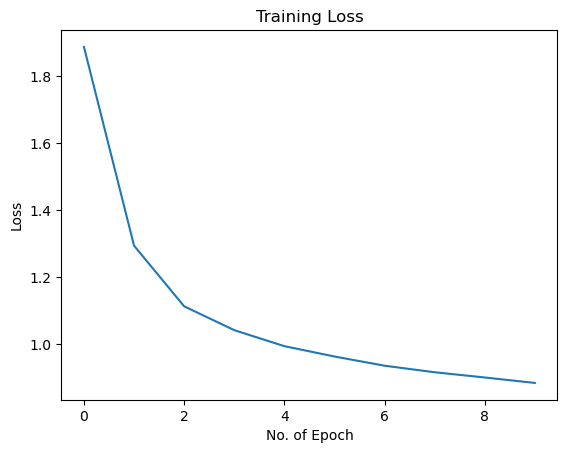

In [ ]:
plt.plot(range(epochs), train_loss)
plt.xlabel("No. of Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

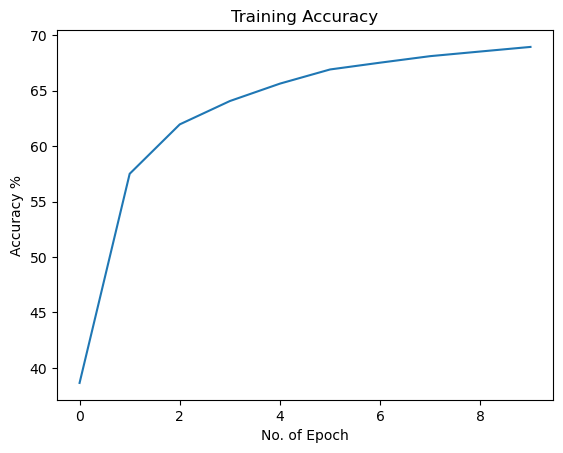

In [ ]:
plt.plot(range(epochs), train_accs)

plt.xlabel("No. of Epoch")
plt.ylabel("Accuracy %")
plt.title("Training Accuracy")
plt.show()

### Evaluate accuracy

Next, compare how the model performs on the test dataset:

In [ ]:
model.eval_classifier(test_loader, device)

100%|██████████| 10000/10000 [00:03<00:00, 3089.75it/s]


Trained model Accuracy on testset: 69.54%


### Make predictions

With the model trained, you can use it to make predictions about some images.
Attach a softmax layer to convert the model's linear outputs—[logits](https://developers.google.com/machine-learning/glossary#logits)—to probabilities, which should be easier to interpret.

In [ ]:
predictions = model.predict(test_loader, device)

100%|██████████| 10000/10000 [00:02<00:00, 3393.14it/s]


Graph this to look at the full set of 10 class predictions.

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

### Verify predictions

With the model trained, you can use it to make predictions about some images.

Let's look at the 0th image, predictions, and prediction array. Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percentage (out of 100) for the predicted label.

In [ ]:
test_images = dataset_test.get_images()
test_labels = dataset_test.get_labels()

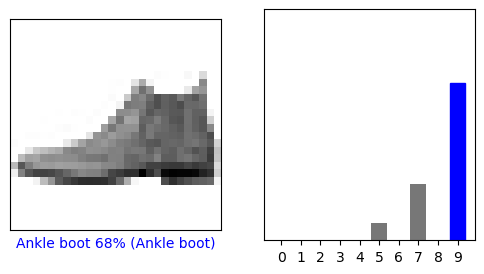

In [ ]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

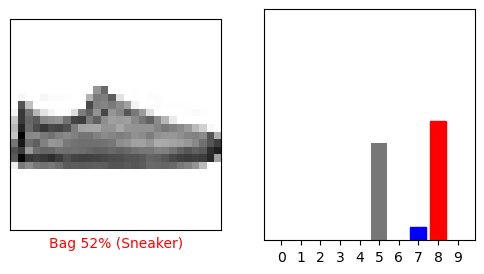

In [ ]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

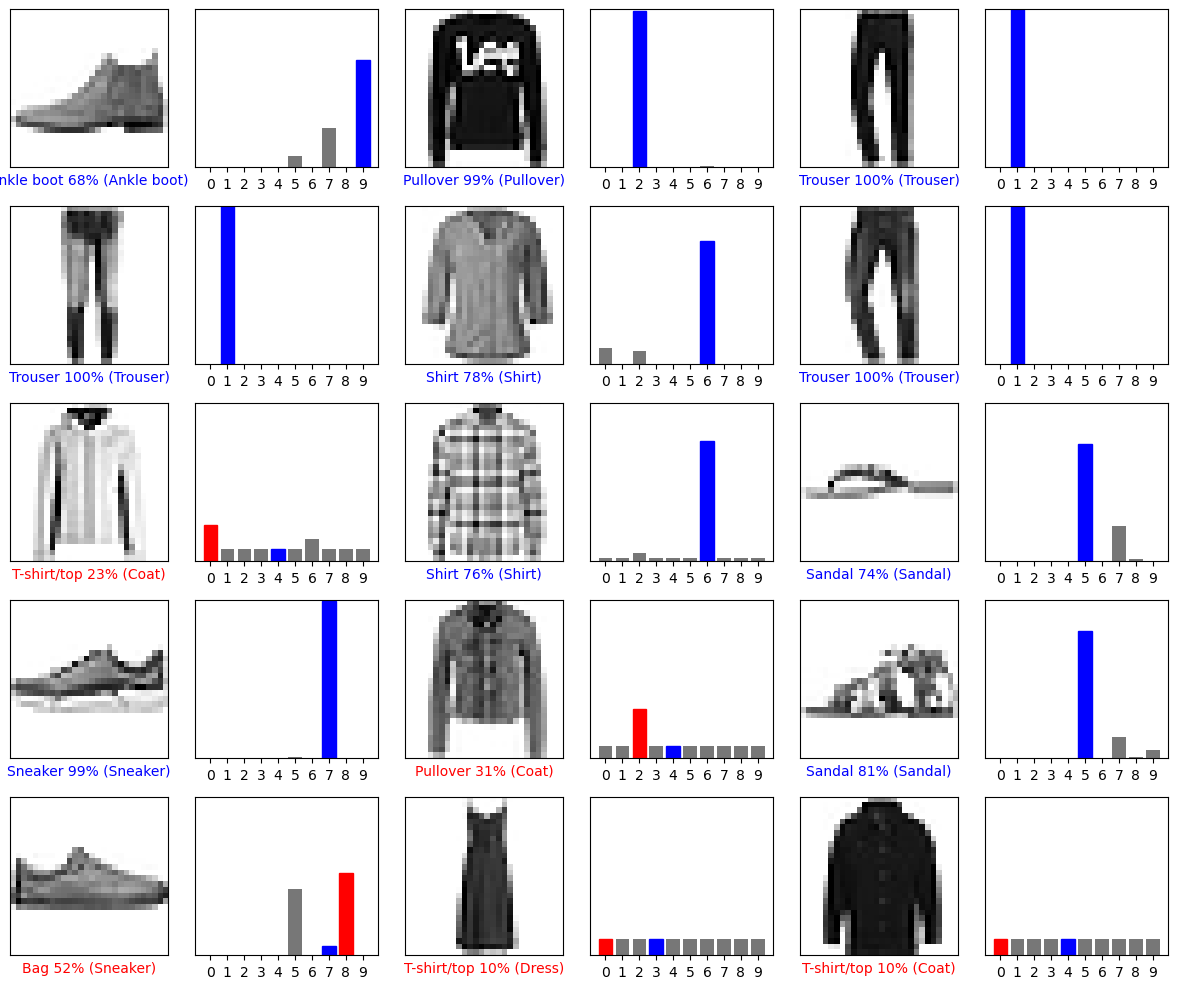

In [ ]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()